In [41]:
%pylab inline
import json
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from datetime import datetime


%pylab inline
import json
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import sklearn
import pandas as pd
from typing import Tuple
from typing import List
import numpy as np
dataset = pd.read_csv('all_data_labelled.csv')
dataset.eeg = dataset.eeg.map(json.loads)
dataset['date']=pd.to_datetime(dataset['date'])
dataset['rawEEG']=dataset['eeg']
dataset=dataset.sort_values(by='date')

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


/Users/sanaiqbal/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plot', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/Users/sanaiqbal/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# add phase information

In [42]:
def get_phase(date):
    date1 = datetime.datetime.strptime('2017-10-10', "%Y-%m-%d")
    days=(date-date1).days
    
    if days<0:
        days=30+days
    if days>30:
        days=days-30
        
    return days

dataset['phase_distance']=dataset['date'].apply(lambda x:get_phase(x))
dataset['phase_no']=pd.cut(dataset['phase_distance'],bins=[-1,5,14,15,31],labels=[1,2,3,4])

In [43]:
def pickup_random_sample(raw_reading):
    pick_len = 512 #length of chunk we want to choose
    total_len = len(raw_reading)
    start_pt = np.random.randint(total_len - pick_len)
    segment = raw_reading[start_pt:start_pt+pick_len]
    return to_power_spectrum_df(segment)

def to_power_spectrum_df(raw_readings):
    '''
    Take raw voltages,
    transform into frequency domain,
    return a power spectrum.
    
    '''
    sampling_rate=len(raw_readings) # --512
    # FFT the raw readings
    fftd = np.fft.fft(raw_readings)
    # take absolute value
    # producing a symmetrical power spectrum
    ps = np.abs(fftd)**2
    # since the power spectrum is symmetrical, 
    # take half
    half_len = len(ps)//2
    ps = ps[:half_len]
#     # we'll calculate the frequencies
    window_size = len(raw_readings)
    freqs = numpy.fft.fftfreq(window_size,d=1/sampling_rate)
#     # splitting that in half to match
    freqs = freqs[:half_len]
    power_spectrum = {
        'frequency (Hz)': freqs,
        'magnitude': ps,
    }
    return power_spectrum['magnitude']

In [44]:
dataset["segment"] = dataset.rawEEG.apply(pickup_random_sample)

## Plotting

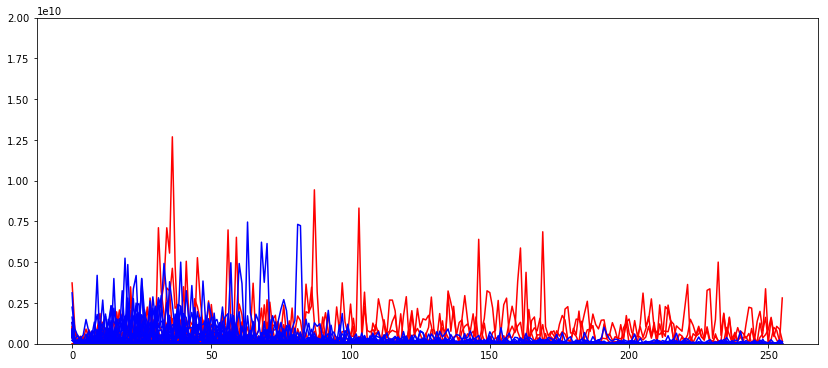

In [45]:
def plot(dataset):
    fig = plt.figure(figsize=(14,6))
    task1 = "baseline"
    task2 = "cognitive"
    all_task1 = dataset[dataset.task=="baseline"].segment.tolist()
    all_task2 = dataset[dataset.task!="baseline"].segment.tolist()
    for i in range(len(all_task1)):
        plt.plot(all_task1[i],'r')
        
    for i in range(len(all_task2)):
        plt.plot(all_task2[i],'b')
    plt.ylim(0,2e10)
    plt.show()

plot(dataset)

## Collecting multiple data segments

In [53]:
def break_and_transform(raw_reading):
    step = 512
    start = 0
    total_len = len(raw_reading)
    current_len = 0
    
    transformations= []
    while current_len+step < total_len:
        chunk = raw_reading[current_len:current_len+step]
        transformations.append(to_power_spectrum_df(chunk))
        current_len+=step
    return transformations

all_entries = []
for i in range(dataset.shape[0]):
    row_data = dataset.iloc[i]
    raw_eeg = row_data.rawEEG
    row_phase=row_data.phase_distance
    transformations = break_and_transform(raw_eeg)
    
    for transform in transformations:
        dict_entry = {"segment":transform,"date":row_data.date,"task":row_data.task,'phase':row_phase,'phase_no':row_data.phase_no}
        all_entries.append(dict_entry)
    

In [54]:
full_df = pd.DataFrame(all_entries)
full_df.head()

,date,phase,phase_no,segment,task
0,2017-10-08,28,4,"[484440100.0, 2012083.63196, 1510549.47118, 12...",baseline
1,2017-10-08,28,4,"[500730129.0, 3848207.48493, 1726082.86518, 56...",baseline
2,2017-10-08,28,4,"[1068047761.0, 62160325.2306, 12017042.0953, 1...",baseline
3,2017-10-08,28,4,"[366186496.0, 8659819.72272, 62033331.7184, 22...",baseline
4,2017-10-08,28,4,"[679749184.0, 73076207.7006, 76062824.6945, 15...",baseline


In [55]:
dataset['task'].value_counts()

cognitive    42
baseline     23
Name: task, dtype: int64

In [56]:
X = np.array(full_df.segment.tolist())
y = (full_df.task=="baseline").values.astype('int')

# reduce dimensions of X

In [57]:
from sklearn.manifold import TSNE

# # Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
tsn= tsne.fit_transform(X)


In [58]:
tsn.shape

(2556, 2)

In [68]:
phase=np.array(full_df['phase']).reshape(2556,1)


In [85]:
X2 = np.hstack((tsn,phase))
X2.shape

(2556, 3)

## Clustering

In [69]:
X.shape

(2556, 256)

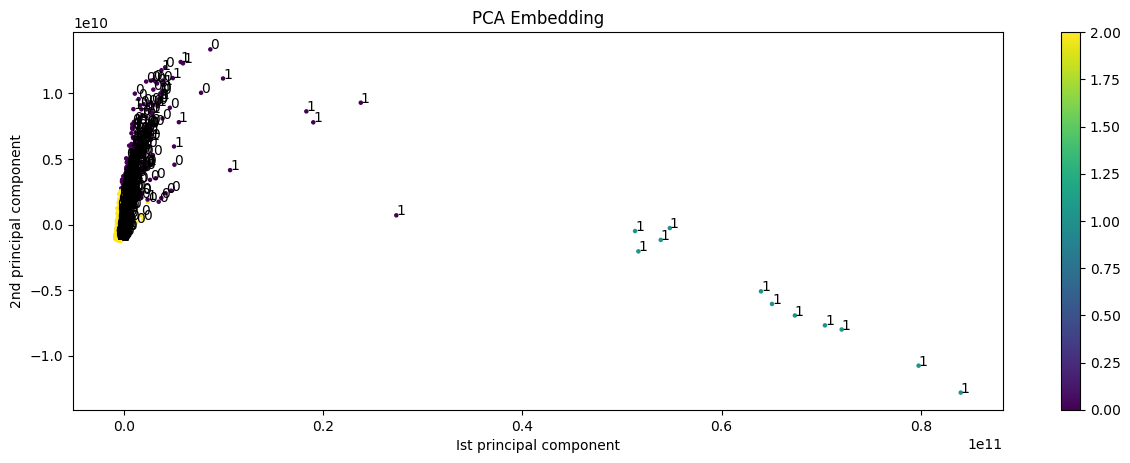

In [70]:
from collections import defaultdict
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
cluster_labels= kmeans.predict(X).tolist()

"""check pca clusteed result"""

from sklearn import decomposition
# get two principle components of the feature space
pca= decomposition.PCA(n_components=2).fit_transform(X)

# set figure settings
plt.figure(figsize=(15,5),dpi=100)

# save pca values and vocab in dataframe df
df = pd.concat([pd.DataFrame(pca),pd.Series(y)],axis=1)
df.columns = ['x', 'y', 'isbaseline']

plt.xlabel("Ist principal component")
plt.ylabel('2nd principal component')

plt.scatter(x=pca[:, 0], y=pca[:, 1],s=5,c=(cluster_labels))
for i, entry in enumerate(df['isbaseline']):
    plt.annotate(entry, (df['x'].iloc[i], df['y'].iloc[i]))
plt.title("PCA Embedding")
plt.colorbar()
plt.show()


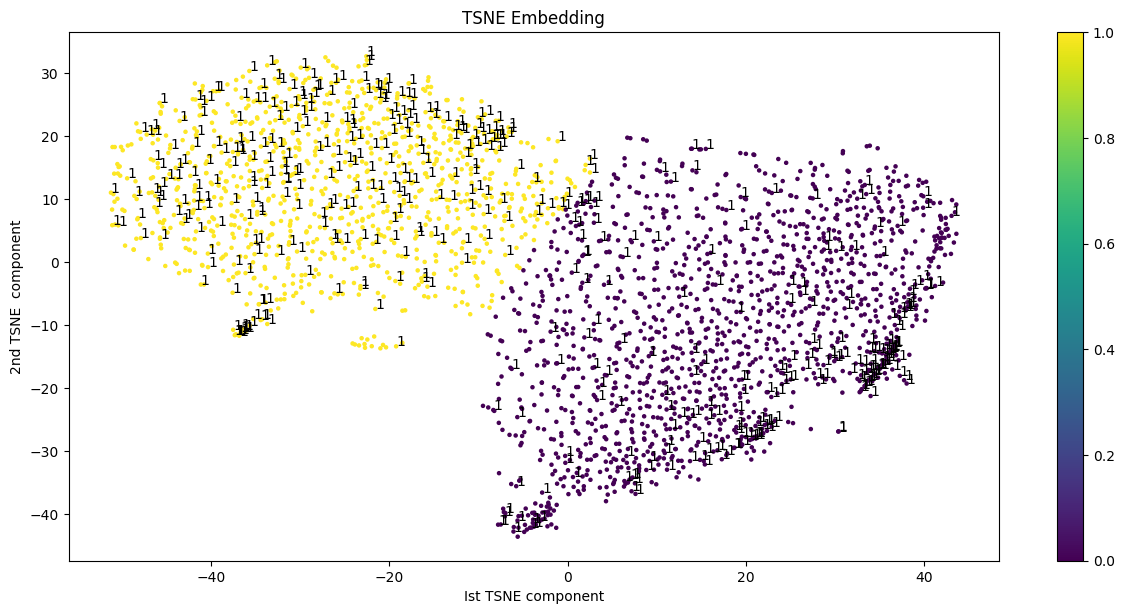

In [71]:


"""check tsne clusteed result"""
kmeans = KMeans(n_clusters=2)
kmeans.fit(tsn)
cluster_labels= kmeans.predict(tsn).tolist()




# set figure settings
plt.figure(figsize=(15,7),dpi=100)

df = pd.concat([pd.DataFrame(tsn),pd.Series(y)],axis=1)
df.columns = ['x', 'y', 'isbaseline']

plt.xlabel("Ist TSNE component")
plt.ylabel('2nd TSNE  component')

plt.scatter(x=tsn[:, 0], y=tsn[:, 1],s=5,c=(cluster_labels))
for i, entry in enumerate(df['isbaseline']):
    if entry==0:
        entry=""
    plt.annotate(entry, (df['x'].iloc[i], df['y'].iloc[i]))
plt.title("TSNE Embedding")
plt.colorbar()
plt.show()


## Classification

In [25]:
clf = LogisticRegression(max_iter=2000,class_weight='balanced')
'''on eeg '''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scores = cross_val_score(clf, X, y, cv=5)
print(mean(scores))
clf.fit(X_train,y_train)
y_predicted = clf.predict(X_test)
print('v:',clf.score(X_test,y_test))
confusion_matrix(y_test,y_predicted)

0.616619526663
v: 0.66796875


array([[290, 116],
       [ 54,  52]])

In [72]:
clf = LogisticRegression(max_iter=2000,class_weight='balanced')
'''only on tsne'''

X_train, X_test, y_train, y_test = train_test_split(tsn, y, test_size=0.2, random_state=42)
scores = cross_val_score(clf, tsn, y, cv=5)
print(mean(scores))
clf.fit(X_train,y_train)
y_predicted = clf.predict(X_test)
print('v:',clf.score(X_test,y_test))
confusion_matrix(y_test,y_predicted)

0.556798862524
v: 0.6328125


array([[261, 145],
       [ 43,  63]])

In [65]:
clf = LogisticRegression(max_iter=2000,class_weight='balanced')
'''on tsn and phase'''
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
scores = cross_val_score(clf, X2, y, cv=5)
print(mean(scores))
clf.fit(X_train,y_train)
y_predicted = clf.predict(X_test)
print('v:',clf.score(X_test,y_test))
confusion_matrix(y_test,y_predicted)

0.453907014432
v: 0.59375


array([[247, 159],
       [ 49,  57]])

0.734375
v: 0.734375
[[305 101]
 [ 35  71]]


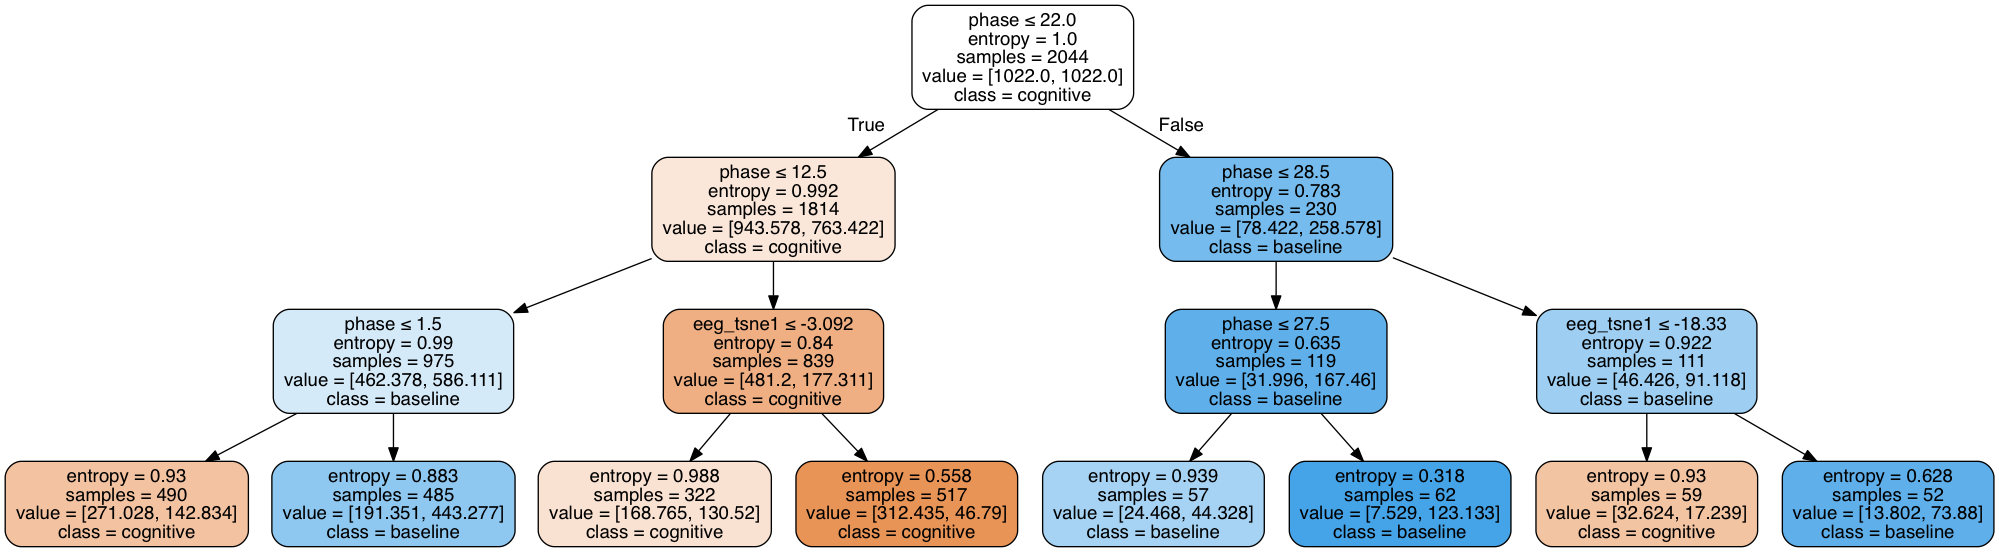

In [86]:
from sklearn import tree
dt = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=3, min_samples_split=2, class_weight='balanced')
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

fit=dt.fit(X_train,y_train)
score =dt.score(X_test,y_test)
print(score)
y_predicted = dt.predict(X_test)
print('v:',dt.score(X_test,y_test))
print(confusion_matrix(y_test,y_predicted))
feature_labels=['eeg_tsne1','eeg_tsne2','phase']
from IPython.display import Image  
import pydotplus 
dot_data = sklearn.tree.export_graphviz(fit, out_file=None,feature_names=feature_labels,class_names=['cognitive','baseline'],filled=True, rounded=True,special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data)
# graph.write_pdf('name.pdf')
Image(graph.create_png())


## Cosine similarity

In [75]:
def get_cosine_similarity(a,b):
    a = np.array(a)
    b = np.array(b)
    return dot(a,b)/(norm(a)*norm(b))

In [76]:
dataset_baseline = dataset[dataset.task=="baseline"].copy(deep=True)
dataset_cognitive = dataset[dataset.task!="baseline"].copy(deep=True)
dataset_baseline = dataset_baseline.reset_index(drop=True)
dataset_cognitive = dataset_cognitive.reset_index(drop=True)

date_list_baseline = dataset_baseline.date.tolist()
segments_list_baseline = dataset_baseline.segment.tolist()

date_list_cognitive = dataset_cognitive.date.tolist()
segments_list_cognitive = dataset_cognitive.segment.tolist()

In [77]:
baseline_comparisons = []
for segment1 in segments_list_baseline:
    curr_list = []
    for segment2 in segments_list_baseline:
        curr_list.append(get_cosine_similarity(segment1,segment2))
    baseline_comparisons.append(np.array(curr_list))
    
cognitive_comparisons = []
for segment1 in segments_list_cognitive:
    curr_list = []
    for segment2 in segments_list_cognitive:
        curr_list.append(get_cosine_similarity(segment1,segment2))
    cognitive_comparisons.append(np.array(curr_list))

In [78]:
baseline_date_pretty=date_list_baseline
cognitive_date_pretty=date_list_cognitive

In [79]:
# baseline_date_pretty = list(map(lambda x:datetime.strptime(str(x),'%Y%m%d').strftime('%m-%d'),date_list_baseline))

# cognitive_date_pretty = list(map(lambda x:datetime.strptime(str(x),'%Y%m%d').strftime('%m-%d'),date_list_cognitive))

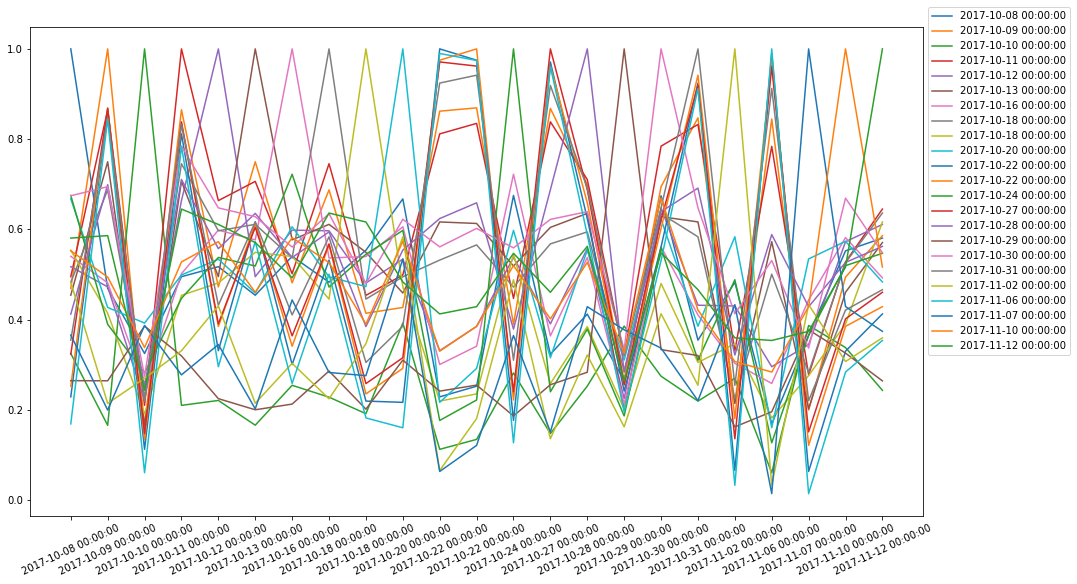

In [80]:
fig, axes = plt.subplots(1, 1, figsize=(16, 9))
for i in range(len(baseline_comparisons)):
    axes.plot(baseline_comparisons[i],label=baseline_date_pretty[i])
axes.set_xticklabels(baseline_date_pretty)
plt.xticks(rotation=25)
plt.xticks(np.arange(0, len(baseline_date_pretty), 1.0))
plt.legend(bbox_to_anchor=(1.0, 1.05))
plt.show()

In [81]:
def plot_date_similarity(comparisons, date_list, task):
    fig = plt.figure(figsize=(16,16))
    ax = fig.add_subplot(111)
    cax = ax.matshow(comparisons) # use matshow method of of Matplotlib to generate the confusion matrix plot. 
    #To get a temperature scale of the colors used in the plot, call the colorbar method:
    ticks = numpy.arange(0,len(date_list),1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(date_list)
    ax.set_yticklabels(date_list)
    plt.xticks(rotation=25)
    plt.colorbar(cax)

    plt.title("Cosine Similarity of "+ task+" task across different days")
    plt.show()

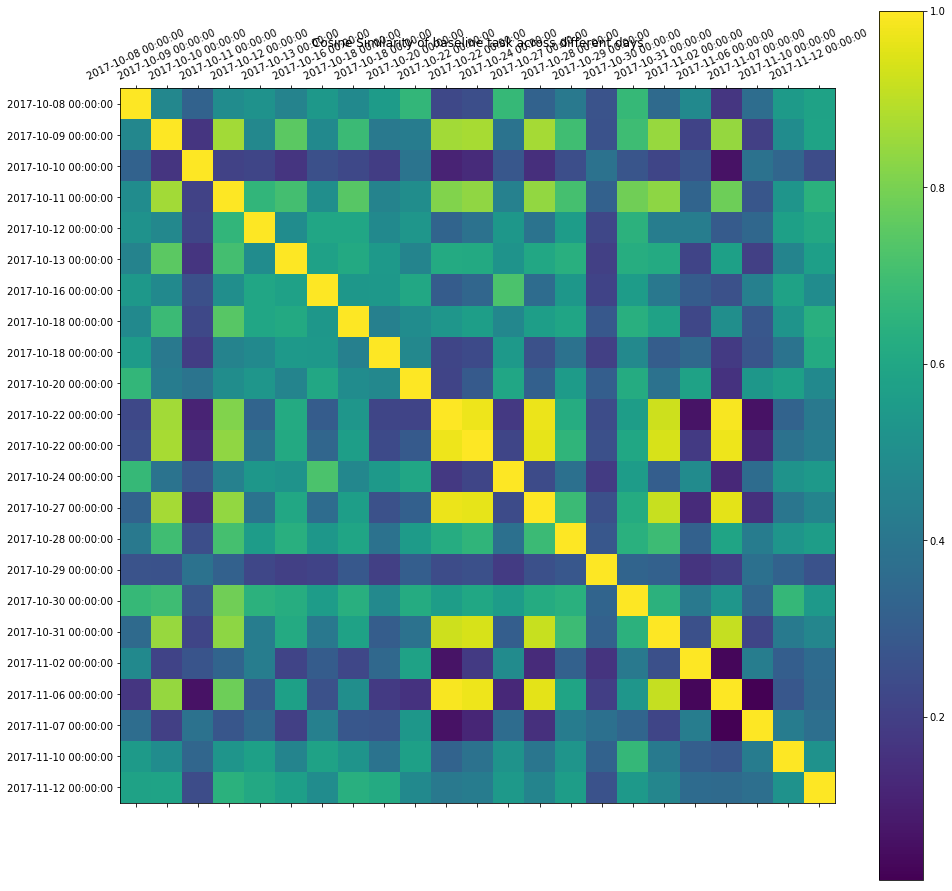

In [82]:
plot_date_similarity(baseline_comparisons, baseline_date_pretty, "baseline")

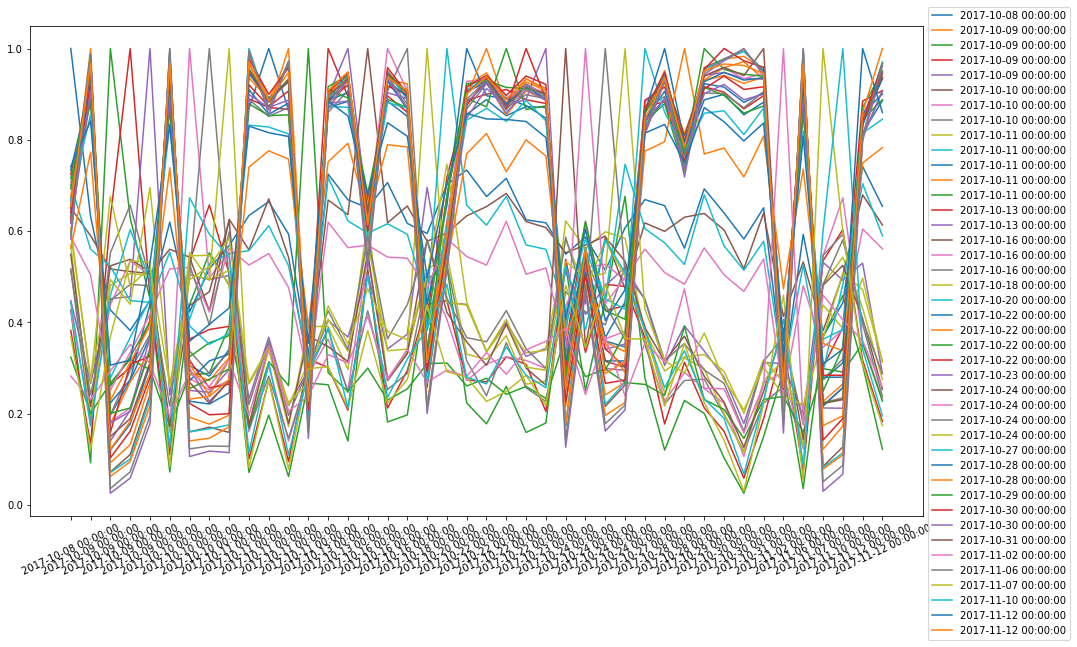

In [83]:
fig, axes = plt.subplots(1, 1, figsize=(16, 9))
for i in range(len(cognitive_comparisons)):
    axes.plot(cognitive_comparisons[i],label=cognitive_date_pretty[i])
axes.set_xticklabels(cognitive_date_pretty)
plt.xticks(rotation=25)
plt.xticks(np.arange(0, len(cognitive_date_pretty), 1.0))
plt.legend(bbox_to_anchor=(1.0, 1.05))
plt.show()

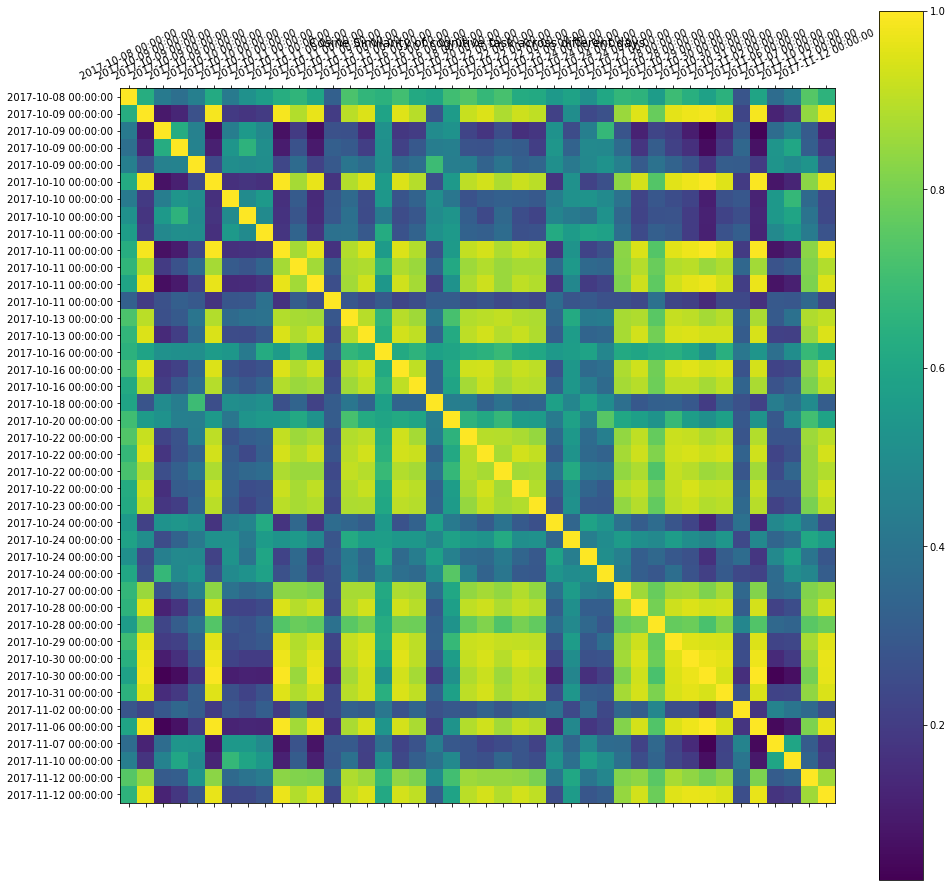

In [84]:
plot_date_similarity(cognitive_comparisons, cognitive_date_pretty, "cognitive")